# Weather Prediction comparing Linear Regression vs LSTM Model

## Imports and configuration

In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # type: ignore MinMaxScaler performed more poorly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # type: ignore
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore

from typing import Any  # noqa: E402
import tensorflow as tf

from sklearn.model_selection import train_test_split

plt.style.use("seaborn-v0_8")
RANDOM_SEED: int = 42
np.random.seed(RANDOM_SEED)

TARGET_COLUMN: str = "MeanTemp"  # the column to predict

TRAIN_RATIO: float = 0.70  # proportion of data to use for training
VALIDATION_RATIO: float = 0.15  # proportion of data to use for validation

## Test GPU Availability

In [2]:
if gpus := tf.config.list_physical_devices("GPU"):
    print(f"GPUs available: {gpus}")
    try:
        # Optional: restrict TensorFlow to the first GPU
        tf.config.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(f"Using GPU: {logical_gpus}")
    except RuntimeError as e:
        print(f"GPU config error: {e}")
else:
    print("No GPU found, running on CPU.")


No GPU found, running on CPU.


## Data Pre Processing

### Load and inspect data

In [3]:
DATA_PATH: Path = Path("Summary of Weather.csv")

df: pd.DataFrame = pd.read_csv(DATA_PATH)
df.head()

C:\Users\arisn\AppData\Local\Temp\ipykernel_11896\542536023.py:3: DtypeWarning: Columns (0: Snowfall, 1: PoorWeather, 2: SNF, 3: TSHDSBRSGF) have mixed types. Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = pd.read_csv(DATA_PATH)


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Show basic info

In [4]:
df.info()
df.describe(include="all").T

<class 'pandas.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  str    
 2   Precip       119040 non-null  str    
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  str    
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-null  objec

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
STA,119040.0,NaN,NaN,NaN,29659.435795,20953.209402,10001.0,11801.0,22508.0,33501.0,82506.0
Date,119040,2192,1945-4-16,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precip,119040,540,0,64267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindGustSpd,532.0,NaN,NaN,NaN,37.774534,10.297808,18.52,29.632,37.04,43.059,75.932
MaxTemp,119040.0,NaN,NaN,NaN,27.045111,8.717817,-33.333333,25.555556,29.444444,31.666667,50.0
MinTemp,119040.0,NaN,NaN,NaN,17.789511,8.334572,-38.333333,15.0,21.111111,23.333333,34.444444
MeanTemp,119040.0,NaN,NaN,NaN,22.411631,8.297982,-35.555556,20.555556,25.555556,27.222222,40.0
Snowfall,117877.0,42.0,0.0,86090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PoorWeather,34237,39,1,25846,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YR,119040.0,NaN,NaN,NaN,43.805284,1.136718,40.0,43.0,44.0,45.0,45.0


### Drop columns with no data

In [5]:
print("Original columns:", df.columns.tolist())
print(len(df.columns))
df = df.dropna(axis=1, how="all")

print("Remaining columns:", df.columns.tolist())
print(len(df.columns))

Original columns: ['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']
31
Remaining columns: ['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'PGT', 'TSHDSBRSGF']
22


### Drop Meaningless Columns

In [6]:
columns_to_drop = ["PoorWeather", "TSHDSBRSGF", "PRCP"]

df = df.drop(columns=columns_to_drop)

### Drop Duplicate Columns

In [7]:
print(f"Duplicated columns: {df.duplicated().sum()}")

if df.duplicated().sum() > 0:
    df = df.drop_duplicates()

int(df.duplicated().sum())

Duplicated columns: 10


0

## Select features and basic preprocessing

### Define Features

In [8]:
CATEGORICAL_COLUMNS: list[str] = ["STA"]

STANDARD_FEATURES: list[str] = [
    "STA",  # station identifier, predictions should be grouped per station
    # "WindGustSpd",
    "MaxTemp",
    "MinTemp",
    "MeanTemp",
    # "PGT",
    # "YR",
    "MO",
    # "DA",
    # added columns
    "DayOfYear",
]

ROBUST_FEATURES: list[str] = ["Snowfall", "Precip"]

ALL_FEATURES = STANDARD_FEATURES + ROBUST_FEATURES

In [9]:
df_model: pd.DataFrame = df.copy()

# Handle 'T' in precipitation-like columns if they exist
for col in ["Precip", "PRCP"]:
    if col in df_model.columns:
        if df_model[col].dtype in ("str", "object"):
            df_model[col] = df_model[col].replace("T", 0.0)
        # Cast to float
        df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# Convert any remaining object columns that look numeric
for col in df_model.columns:
    if df_model[col].dtype == "object":
        # Try to coerce to numeric, keep non-numeric as NaN
        df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# Parse date and sort
df_model["Date"] = pd.to_datetime(df_model["Date"])

# add day of year feature for seasonality
df_model["DayOfYear"] = df_model["Date"].dt.dayofyear

df_model = df_model.sort_values("Date").reset_index(drop=True)

# Keep only needed columns + Date for reference
columns_to_use: list[str] = ["Date"] + ALL_FEATURES
df_model = df_model[columns_to_use].copy()

# Drop rows with any missing selected feature values
df_model = df_model.dropna(subset=ALL_FEATURES).reset_index(drop=True)
df_model.head(5)

,Date,STA,MaxTemp,MinTemp,MeanTemp,MO,DayOfYear,Snowfall,Precip
0,1940-01-01,22504,26.666667,17.222222,22.222222,1,1,0.0,2.286
1,1940-01-01,10701,28.333333,22.222222,25.555556,1,1,0.0,7.620
2,1940-01-01,22508,23.333333,17.222222,20.000000,1,1,0.0,0.254
3,1940-01-02,10701,28.888889,23.333333,26.111111,1,2,0.0,15.240
4,1940-01-02,22508,23.333333,16.111111,19.444444,1,2,0.0,10.160


### Shared Code

In [10]:
def plot_predictions(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: str = "Actual vs predicted MeanTemp",
    n_points: int = 300,
) -> None:
    """
    Plot actual vs predicted time series.

    Parameters
    ----------
    y_true : np.ndarray
        True target values in original units.
    y_pred : np.ndarray
        Predicted target values in original units.
    title : str
        Title of the plot.
    n_points : int
        Number of last points to plot for readability.
    """
    n = len(y_true)
    start: int = max(0, n - n_points)

    plt.figure(figsize=(12, 4))
    plt.plot(range(start, n), y_true[start:], label="Actual")
    plt.plot(range(start, n), y_pred[start:], label="Predicted")
    plt.xlabel("Time index (relative)")
    plt.ylabel("MeanTemp")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2


## Linear Regression Baseline

### Train Linear Regresion Model

In [11]:
df_clean_linear = df_model.copy().dropna(subset=[TARGET_COLUMN]).reset_index(drop=True)

target_candidates = [c for c in df.columns if c in [TARGET_COLUMN]]
target_col = target_candidates[0]

numeric_cols = df_clean_linear.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

X_lin = df_clean_linear[numeric_cols]
y_lin = df_clean_linear[target_col]

# --- Ensure no NaNs before splitting: impute with column means ---
X_lin = X_lin.replace([np.inf, -np.inf], np.nan)  # just in case
X_lin = X_lin.fillna(X_lin.mean())

test_size = 1.0 - TRAIN_RATIO - VALIDATION_RATIO

X_train_lin, X_test_lin, y_train_lin, y_lin_test = train_test_split(
    X_lin, y_lin, test_size=test_size, random_state=RANDOM_SEED
)

X_test_lin.head()

,STA,MaxTemp,MinTemp,MO,DayOfYear,Snowfall,Precip
99100,50403,31.666667,22.222222,6,166,0.0,0.000
31724,30001,30.000000,21.666667,10,274,0.0,13.716
66331,33303,32.777778,22.222222,8,243,0.0,0.000
6367,16405,3.888889,-6.666667,4,107,0.0,0.000
111312,34113,21.111111,12.222222,10,288,0.0,0.000


### Run Linear Regression Model

In [12]:
# Train model
lin_reg = LinearRegression()
lin_reg.fit(X_train_lin, y_train_lin)

# Predictions
y_train_pred = lin_reg.predict(X_train_lin)
y_test_pred = lin_reg.predict(X_test_lin)


### Validate Linear Regression Accuracy

In [13]:
train_mse, train_rmse, train_mae, train_r2 = regression_metrics(
    y_train_lin, y_train_pred
)
test_mse, test_rmse, test_mae, test_r2 = regression_metrics(y_lin_test, y_test_pred)

print("=== Train metrics ===")
print(f"MSE : {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE : {train_mae:.4f}")
print(f"R²  : {train_r2:.4f}")

print("\n=== Test metrics ===")
print(f"MSE : {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")
print(f"R²  : {test_r2:.4f}")

=== Train metrics ===
MSE : 0.2640
RMSE: 0.5138
MAE : 0.1667
R²  : 0.9959

=== Test metrics ===
MSE : 0.2527
RMSE: 0.5027
MAE : 0.1676
R²  : 0.9962


### Plot Predictions Linear Regression

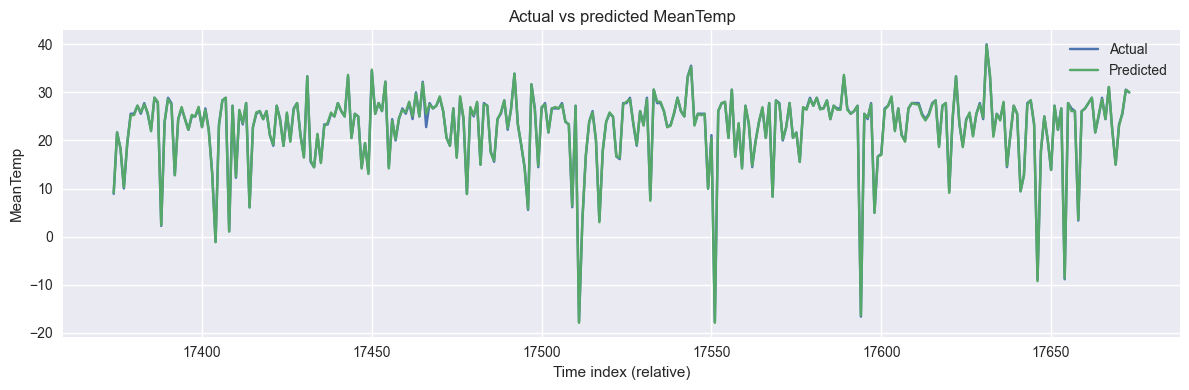

17674
17674


In [14]:
plot_predictions(y_lin_test.values, y_test_pred, n_points=300)

print(len(y_lin_test.values))
print(len(y_test_pred))

## LSTM Analysis

### Define Parameters

In [15]:
STA_WEIGHT: float = 2.0
LOOKBACK: int = 14  # use last x days to predict next day
PATIENCE: int = 3  # early stopping patience
EPOCHS: int = 50  # maximum number of training epochs
BATCH_SIZE: int = 64  # training batch size, reducing batch size improves accuracy but increases training time
DENSE_LAYER: int = 64  # number of neurons in dense layer
ACTIVATION: str = "relu"  # activation function for dense layer
LSTM_UNITS: int = 256
DROPOUT_RATE: float = 0.20  # dropout rate for regularization

# scaler to use for data normalization
# scaler: MinMaxScaler = MinMaxScaler(feature_range=(0, 1)) # performs worse than standard scaler
standard_scaler: Any = StandardScaler() # to use in LSTM RNN model

### Build supervised sequences for LSTM

In [16]:
def create_sequences(
    data: np.ndarray, target_index: int, lookback: int
) -> tuple[np.ndarray, np.ndarray]:
    """
    Create (X, y) sequences for LSTM from multivariate time series.

    Parameters
    ----------
    data : np.ndarray
        Time-series data of shape (n_samples, n_features).
    target_index : int
        Index of the feature column to be predicted.
    lookback : int
        Number of past time steps used as input.

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        X of shape (n_sequences, lookback, n_features),
        y of shape (n_sequences,).
    """
    X_list: list[np.ndarray] = []
    y_list: list[float] = []

    for i in range(lookback, len(data)):
        X_list.append(data[i - lookback : i])
        y_list.append(data[i, target_index])

    X: np.ndarray = np.array(X_list)
    y: np.ndarray = np.array(y_list)

    return X, y


### Scaling and sequence creation

In [17]:
# Extract feature values
features: np.ndarray = df_model[ALL_FEATURES].values

scaled_features: np.ndarray = standard_scaler.fit_transform(features)

target_index: int = ALL_FEATURES.index(TARGET_COLUMN)

X_all, y_all = create_sequences(
    data=scaled_features, target_index=target_index, lookback=LOOKBACK
)

X_all.shape, y_all.shape


((117809, 14, 8), (117809,))

### Train/validation/test split

In [18]:
def train_val_test_split(
    X: np.ndarray, y: np.ndarray, train_ratio: float = 0.7, val_ratio: float = 0.15
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split time-series data into train, validation, and test partitions
    preserving temporal order.

    Parameters
    ----------
    X : np.ndarray
        Input sequences of shape (n, lookback, n_features).
    y : np.ndarray
        Targets of shape (n,).
    train_ratio : float
        Fraction of samples for training.
    val_ratio : float
        Fraction of samples for validation.

    Returns
    -------
    tuple of arrays
        X_train, y_train, X_val, y_val, X_test, y_test.
    """
    n_samples: int = len(X)
    train_end: int = int(n_samples * train_ratio)
    val_end: int = int(n_samples * (train_ratio + val_ratio))

    X_train = X_all[:train_end]
    y_train = y_all[:train_end]

    X_val = X_all[train_end:val_end]
    y_val = y_all[train_end:val_end]

    X_test = X_all[val_end:]
    y_test = y_all[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    X_all, y_all, val_ratio=VALIDATION_RATIO, train_ratio=TRAIN_RATIO
)

X_train.shape, X_val.shape, X_test.shape


((82466, 14, 8), (17671, 14, 8), (17672, 14, 8))

### Define and train LSTM model

In [19]:
def build_lstm_model(
    input_shape: tuple[int, int],
    lstm_units: int = 128,
    dropout_rate: float = 0.5,
) -> Sequential:
    """
    Build a simple LSTM regression model in Keras.

    Parameters
    ----------
    input_shape : tuple[int, int]
        Shape (lookback, n_features) for the input.
    lstm_units : int
        Number of LSTM units.
    dropout_rate : float
        Dropout rate after the LSTM layer.

    Returns
    -------
    Sequential
        Compiled Keras model.
    """
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(DENSE_LAYER, activation=ACTIVATION))
    model.add(Dense(1))  # regression output

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"],
    )
    return model


input_shape: tuple[int, int] = (X_train.shape[1], X_train.shape[2])
model: Sequential = build_lstm_model(
    input_shape=input_shape, lstm_units=LSTM_UNITS, dropout_rate=DROPOUT_RATE
)
model.summary()


c:\dev\mary\ml-mid-assignment\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       271,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,873 (1.10 MB)

 Trainable params: 287,873 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Train model with early stopping

In [20]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1,
)


Epoch 1/50


1289/1289 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 1.0029 - mae: 0.6863 - val_loss: 0.8604 - val_mae: 0.6721
Epoch 2/50
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.9966 - mae: 0.6830 - val_loss: 0.8535 - val_mae: 0.6966
Epoch 3/50
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.9933 - mae: 0.6818 - val_loss: 0.8573 - val_mae: 0.6970
Epoch 4/50
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.9891 - mae: 0.6816 - val_loss: 0.8519 - val_mae: 0.6925
Epoch 5/50
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.9882 - mae: 0.6813 - val_loss: 0.8516 - val_mae: 0.6885
Epoch 6/50
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.9866 - mae: 0.6810 - val_loss: 0.8519 - val_mae: 0.6897
Epoch 7/50
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.9845 - mae: 0.6803 - val_loss: 0.8553 - val_mae: 0.6936
Epoch 8/50
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.9832 - mae: 0.6800 - val_loss: 0.8517 - val_mae: 0.6796


### Visualize training loss and MAE

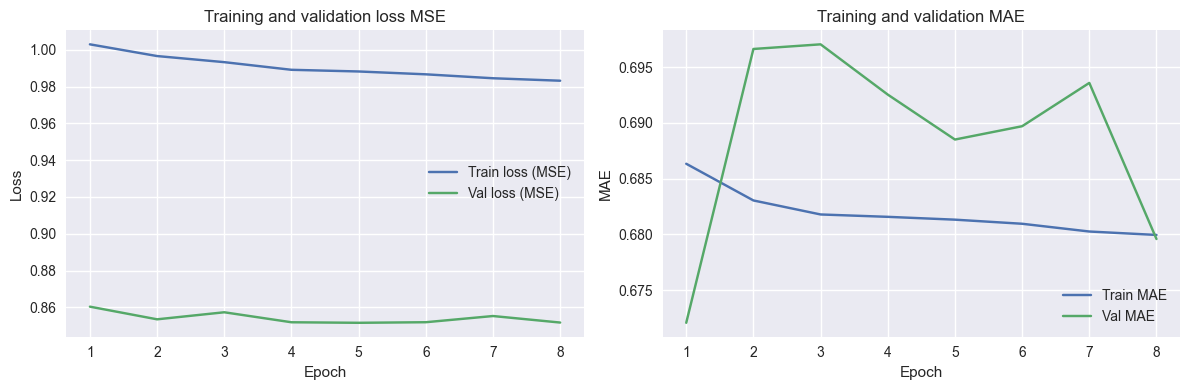

In [21]:
def plot_training_history(history) -> None:
    """
    Plot training and validation loss and MAE over epochs.
    """
    history_dict = history.history
    epochs = range(1, len(history_dict["loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, history_dict["loss"], label="Train loss (MSE)")
    axes[0].plot(epochs, history_dict["val_loss"], label="Val loss (MSE)")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training and validation loss MSE")
    axes[0].legend()

    axes[1].plot(epochs, history_dict["mae"], label="Train MAE")
    axes[1].plot(epochs, history_dict["val_mae"], label="Val MAE")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("MAE")
    axes[1].set_title("Training and validation MAE")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history)


### Evaluate on test set and compute scores

In [22]:
y_pred_test_scaled: np.ndarray = model.predict(X_test)


# For interpretability, inverse-transform MeanTemp back to original units.
# We need to embed predictions into a full feature vector before inverse scaling.
def inverse_transform_target(
    scaled_target: np.ndarray,
    scaler: Any,
    target_index: int,
) -> np.ndarray:
    """
    Inverse-transform a single target column that was part of a Scaler fit
    on multiple features.

    Parameters
    ----------
    scaled_target : np.ndarray
        Predicted or true target values in scaled space, shape (n_samples, 1) or (n_samples,).
    scaler : Any
        Fitted scaler on the full feature matrix.
    target_index : int
        Index of the target column in the original feature matrix.

    Returns
    -------
    np.ndarray
        Target values in original units, shape (n_samples,).
    """
    scaled_target = np.asarray(scaled_target).reshape(-1, 1)
    n_features: int = scaler.n_features_in_

    # Create dummy zeros for all features, then replace target column
    dummy_scaled = np.zeros((len(scaled_target), n_features))
    dummy_scaled[:, target_index] = scaled_target[:, 0]

    inv_full = scaler.inverse_transform(dummy_scaled)
    return inv_full[:, target_index]


y_test_inv: np.ndarray = inverse_transform_target(y_test, standard_scaler, target_index)
y_pred_test_inv: np.ndarray = inverse_transform_target(
    y_pred_test_scaled, standard_scaler, target_index
)


553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


### Validate Model LSTM

In [23]:
test_mse, test_rmse, test_mae, test_r2 = regression_metrics(y_test_inv, y_pred_test_inv)

print("\n=== Test metrics ===")
print(f"MSE : {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")
print(f"R²  : {test_r2:.4f}")


=== Test metrics ===
MSE : 47.5555
RMSE: 6.8960
MAE : 4.8592
R²  : 0.1219


### Predictions vs Actuals

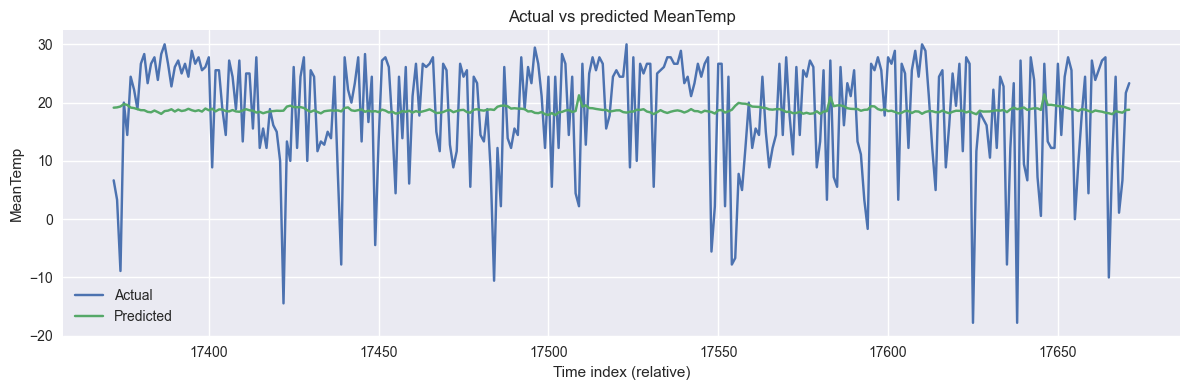

17672
17672


In [24]:
plot_predictions(y_test_inv, y_pred_test_inv, n_points=300)

print(len(y_test_inv))
print(len(y_pred_test_inv))

### Residual analysis

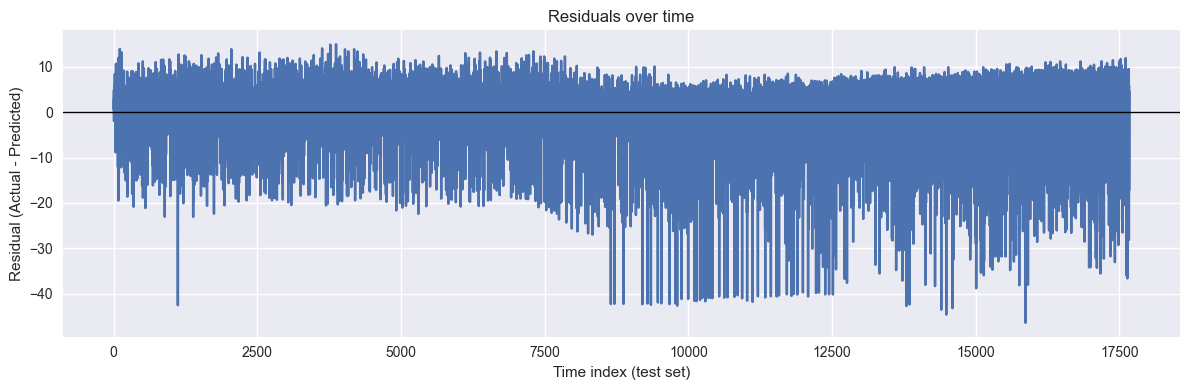

In [25]:
residuals: np.ndarray = y_test_inv - y_pred_test_inv

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Time index (test set)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals over time")
plt.tight_layout()
plt.show()
